### ARIMA 예측모형 생성
- trend : constatnt를 가지고 있는지 c:constant/nc:no constant
- disp : 수렴정보를 나타냄

In [22]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

import pandas as pd
import matplotlib.pyplot as plt

series=pd.read_csv("market-price.csv", header=0, names=['day', 'price'])

#str->datetime
series['day']=pd.to_datetime(series['day'])
#index로 설정
series.index=series['day']
series.set_index('day', inplace=True)

series.head()

,price
day,
2021-08-30,48806.78
2021-08-31,47074.77
2021-09-01,47155.87
2021-09-02,48862.76
2021-09-03,49329.01


In [23]:
from statsmodels.tsa.arima_model import ARIMA

#AR=0, 차분=1, MA=1
model=ARIMA(series, order=(0,1,1))

#trend='c'로 설정
model_fit=model.fit(trend='c', full_output=True, disp=1)
#model_fit=model.fit(trend='nc', full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  365
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3175.080
Method:                       css-mle   S.D. of innovations           1450.859
Date:                Tue, 15 Nov 2022   AIC                           6356.161
Time:                        17:28:15   BIC                           6367.861
Sample:                    08-31-2021   HQIC                          6360.810
                         - 08-30-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -78.1270     77.814     -1.004      0.315    -230.641      74.386
ma.L1.D.price     0.0247      0.060      0.414      0.679      -0.092       0.142
                                    Root

constant의 p-value 0.05 이상이라면, model.fit() 파라미터 중 trned='c'가 아니라 'nc'로 설정해주어야 하는 것이 옳다. 즉 시계열 모형에 상수 값이 필요하지 않다는 것을 의미한다. 

여기서는 const가 아닌 그래프 상에서는 필요하지 않았지만 임의로 추가하였던 MA1이 귀무가설 채택 상태이므로 이를 제외하고 다시 모형을 만들었다.

In [28]:
model = ARIMA(series, order=(0,1,0))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  365
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3175.166
Method:                           css   S.D. of innovations           1451.202
Date:                Tue, 15 Nov 2022   AIC                           6354.333
Time:                        17:31:51   BIC                           6362.132
Sample:                    08-31-2021   HQIC                          6357.432
                         - 08-30-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -78.1270     75.959     -1.029      0.304    -227.005      70.751


MA1이 추가된 모형보다 그냥 차분만 하고 ARMIA(0,1,0)을 한 모형이 AIC, BIC 값이 더 작다. const에 대한 pvalue도 기각상태이므로 해당 변수가 유의하다는 뜻이다.

In [25]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []

    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p, d, q))

                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass

                result_df = pd.DataFrame(list(zip(order_list, aic_list)),
                                         columns=['order', 'AIC'])
                result_df.sort_values(sort, inplace=True)

    return result_df


my_auto_arima(series, [2, 2, 2])

,order,AIC
2,p0 d1 q0,6354.332523
3,p0 d1 q1,6356.160847
6,p1 d1 q0,6356.200218
7,p1 d1 q1,6356.498952
4,p1 d0 q0,6378.356275
5,p1 d0 q1,6380.062378
1,p0 d0 q1,7508.036915
0,p0 d0 q0,7963.308610


최적의 모형은 차분만하고 AR, MA는 안 한 모형으로 나옴

### forecast

기존 날짜의 예측값과 실제 값을 비교해서 시각화하고 forecast로 그 이후에 몇일까지를 예측할 것인지 지정해주면 실제 예측값이 나옴

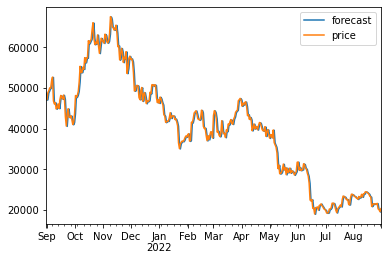

In [26]:
#모형을 통해 예측된 값 확인
model_fit.plot_predict()
plt.show()

#앞으로의 값을 예측(forecast method)
#steps는 예측할 개수를 의미

In [29]:
fore = model_fit.forecast(steps=5)
print(fore)

(array([20212.2829589 , 20134.15591781, 20056.02887671, 19977.90183562,
       19899.77479452]), array([1451.20150206, 2052.30884595, 2513.55473358, 2902.40300412,
       3244.98520765]), array([[17367.98028056, 23056.58563725],
       [16111.7044946 , 24156.60734102],
       [15129.55212572, 24982.50562771],
       [14289.29647893, 25666.5071923 ],
       [13539.72065716, 26259.82893188]]))


코드의 결과는 순서대로 예측값, stderr, upper bound, lower bound이다.

In [30]:
series.tail()

,price
day,
2022-08-26,21597.93
2022-08-27,20233.32
2022-08-28,20035.59
2022-08-29,19550.07
2022-08-30,20290.41


학습에 쓰인 데이터가 2022년 8월30일까지의 데이터이므로 

ARIMA 모형은 8/31(20212), 9/1(20134), 9/2(20056), 9/3(19977), 9/4(19899)로 비트코인 가격을 예측하였다.